In [28]:
import os
import pymongo
import pandas as pd
from dotenv import load_dotenv
from datetime import datetime
import seaborn as sns
from matplotlib import pyplot as plt
from plotly import express as px
from plotly.subplots import make_subplots

load_dotenv()

MONGO_DB_USER = os.environ["MONGO_DB_USER"]
MONGO_DB_PASSWORD = os.environ["MONGO_DB_PASSWORD"]
MONGO_DB_HOST = os.environ["MONGO_DB_HOST"]
MONGO_DB_PORT = os.environ["MONGO_DB_PORT"]

client = pymongo.MongoClient(
    f"mongodb://{MONGO_DB_USER}:{MONGO_DB_PASSWORD}@{MONGO_DB_HOST}:{MONGO_DB_PORT}/"
)

silver_db = client.silver
silver_events = silver_db.events
silver_games = silver_db.games

In [4]:
print("Most recent event in the Database:")

most_recent_event = silver_events.find_one(sort=[("Date", -1)])

print(most_recent_event["Date"])

Most recent event in the Database:
2024-07-09 00:00:00


## Biggest Winners

We'll be analysing the Double Tournament era here, which stated in 01.02.2024 according to Chess.com.

Source: https://www.chess.com/article/view/titled-tuesday


In [5]:
match_double_elimination_era = {
    "$match": {
        "Date": {"$gte": datetime(2022, 1, 31)},
    }
}

winners = silver_events.aggregate(
    [
        match_double_elimination_era,
        {
            "$project": {
                "results": {
                    "$filter": {
                        "input": "$results",
                        "as": "r",
                        "cond": {"$eq": ["$$r.position", 1]},
                    }
                }
            }
        },
    ]
)

dict_winners = {}

for i in winners:
    for winner in i["results"]:
        dict_winners.setdefault(winner["player"], 0)
        dict_winners[winner["player"]] += 1

print(f"Number of Events: {sum(dict_winners.values())}\n")

print(f"Players with most wins")
for key, value in sorted(dict_winners.items(), key=lambda item: item[1], reverse=True)[:10]:
    print(f"{key:>22}: {value}")

Number of Events: 244

Players with most wins
      Nakamura, Hikaru: 55
     Andreikin, Dmitry: 16
       Carlsen, Magnus: 16
         Dubov, Daniil: 11
     Firouzja, Alireza: 9
        Sarana, Alexey: 8
   Duda, Jan-Krzysztof: 8
    Fedoseev, Vladimir: 6
     Bortnyk, Olexandr: 6
        Xiong, Jeffery: 5


During the first data exploration of this dataset it has been found that some players have multiple accounts in the database, this has been corrected during the silver ETL phase and left here for reference.

```python
dict_multiple_accounts = {
    "Nakamura, Hikaru": "Hikaru",
    "Carlsen, Magnus": "MagnusCarlsen",
    "Firouzja, Alireza": "Firouzja2003",
    "Sarana, Alexey": "mishanick",
    "Andreikin, Dmitry": "FairChess_on_YouTube",
    "Duda, Jan-Krzysztof": "Polish_fighter3000",
}

for key, value in dict_multiple_accounts.items():
    dict_winners[key] += dict_winners[value]
    del dict_winners[value]

print(f"Players with most wins")
for key, value in sorted(dict_winners.items(), key=lambda item: item[1], reverse=True)[:10]:
    print(f"{key:>22}: {value}")
```


In [6]:
# Searching if there's any other accounts that may belong to the top players

players_to_search = ["magnus", "carlsen", "hikaru", "nakamura"]

for player in players_to_search:
    total_games_per_player = silver_games.aggregate(
        [
            match_double_elimination_era,
            {"$project": {"White": 1, "Black": 1, "_id": 0}},
            {"$project": {"values": {"$objectToArray": "$$ROOT"}}},
            {"$unwind": "$values"},
            {"$group": {"_id": "$values.v", "count": {"$sum": 1}}},
            {"$sort": {"count": -1}},
            {"$match": {"_id": {"$regex": player, "$options": "i"}}},
        ]
    )

    print(f"Player: {player}")
    for i in total_games_per_player:
        print(f"Games: {i['count']} - Player: {i['_id']}")
    print("\n")

Player: magnus
Games: 758 - Player: Carlsen, Magnus
Games: 5 - Player: CarlMagnuson
Games: 2 - Player: Magnuson, Carl F


Player: carlsen
Games: 758 - Player: Carlsen, Magnus
Games: 31 - Player: carlsenCamacho
Games: 11 - Player: carlsen1001
Games: 7 - Player: BetonCarlsen


Player: hikaru
Games: 1999 - Player: Nakamura, Hikaru
Games: 18 - Player: hikaruchija


Player: nakamura
Games: 1999 - Player: Nakamura, Hikaru




### Notes

No other accounts were found that belong to the top players.


## Biggest upsets

An upset is when one player's rating is lower than the other player's.

Here we'll be looking into which were the biggest upsets in the Double-Tournament Era.


In [7]:
upsets = (
    silver_games.find(
        {
            "WhiteElo": {"$gt": 1000},
            "BlackElo": {"$gt": 1000},
            "Date": {"$gte": datetime(2022, 1, 1)},
        }
    )
    .limit(10)
    .sort({"Upset": 1})
)

upsets = pd.DataFrame(upsets)[["Event", "Upset", "White", "WhiteElo", "Black", "BlackElo"]]

upsets.loc[:, "Chances of Upset %"] = 1 / (1 + 10 ** (-upsets["Upset"] / 400))

upsets.style.format({"Chances of Upset %": "{:.4%}", "Upset": "{:.0f}"})

,Event,Upset,White,WhiteElo,Black,BlackElo,Chances of Upset %
0,Titled Tuesday Blitz December 20 Early 2022,-1619,Susal_De_Silva,2808,"Kazgildy, Fariza",1189,0.0090%
1,Titled Tuesday Blitz October 18 Late 2022,-1546,"Eisa Mohmood, Alkhoori",1245,"Bordi, Kevin",2791,0.0136%
2,Titled Tuesday Blitz December 20 Early 2022,-1536,Kopylov_Alex,2790,"Mone, Ved",1254,0.0145%
3,Titled Tuesday Blitz December 20 Early 2022,-1463,The_Machine04,2652,"Kazgildy, Fariza",1189,0.0220%
4,Titled Tuesday Blitz April 26 Early 2022,-1414,"Bashirli, Saadat",1173,"Bachmann, Axel",2587,0.0292%
5,Titled Tuesday Blitz December 20 Early 2022,-1393,"Benamar, Benious",1136,lemayvega,2529,0.0329%
6,Titled Tuesday Blitz December 20 Early 2022,-1350,CDOEspiao,2486,"Benamar, Benious",1136,0.0422%
7,Titled Tuesday Blitz December 20 Early 2022,-1328,"Castro Andrade, Seirbert Cristian",1364,"Xiong, Jeffery",2692,0.0478%
8,Titled Tuesday Blitz December 20 Early 2022,-1311,"Yildiz, Ayse Emek",1702,OparinGrigoriy,3013,0.0528%
9,Titled Tuesday Blitz January 03 Late 2023,-1309,"Gaehwiler, Gabriel",2404,"Eisa Mohmood, Alkhoori",1095,0.0534%


### Notes

In the tables above we can see that the biggest upset in this tournament had an elo difference of 1619, this had a chance of happening of just 0.009% ([Source](https://fivethirtyeight.com/features/introducing-nfl-elo-ratings/)).


### Carlsen and Nakamura Upsets


In [8]:
print(
    f"Number of games player by Carlsen: {silver_games.count_documents({'$or': [{'White': 'Carlsen, Magnus'}, {'Black': 'Carlsen, Magnus'}]})}"
)

upsets = (
    silver_games.find(
        {
            "$or": [
                {"White": {"$in": ["Carlsen, Magnus"]}},
                {"Black": {"$in": ["Carlsen, Magnus"]}},
            ],
            "WhiteElo": {"$gt": 1000},
            "BlackElo": {"$gt": 1000},
        }
    )
    .limit(5)
    .sort({"Upset": 1})
)

carlsen_upsets = pd.DataFrame(upsets)[["Event", "Upset", "White", "WhiteElo", "Black", "BlackElo"]]

carlsen_upsets.loc[:, "Chances of Upset %"] = 1 / (1 + 10 ** (-carlsen_upsets["Upset"] / 400))

carlsen_upsets.style.format({"Chances of Upset %": "{:.4%}", "Upset": "{:.0f}"})

Number of games player by Carlsen: 787


,Event,Upset,White,WhiteElo,Black,BlackElo,Chances of Upset %
0,Late-Titled-Tuesday-Blitz-June-25-2024,-616,"Carlsen, Magnus",3164,WPWPWP-2015,2548,2.8032%
1,Late-Titled-Tuesday-Blitz-July-02-2024,-612,subham777,2545,"Carlsen, Magnus",3157,2.8666%
2,Titled Tuesday Blitz March 21 Early 2023,-475,"Carlsen, Magnus",2852,"Tillyaev, Ulugbek",2377,6.0978%
3,Late-Titled-Tuesday-Blitz-February-20-2024,-465,ProphetReborn,2860,"Carlsen, Magnus",3325,6.4359%
4,Titled Tuesday Blitz January 31 Late 2023,-440,"Erdogdu, Mert",2413,"Carlsen, Magnus",2853,7.3588%


In [9]:
print(
    f"Number of games player by Hikaru Nakamura: {silver_games.count_documents({'$or': [{'White': 'Nakamura, Hikaru'}, {'Black': 'Nakamura, Hikaru'}]})}"
)

upsets = (
    silver_games.find(
        {
            "$or": [
                {"White": {"$in": ["Nakamura, Hikaru"]}},
                {"Black": {"$in": ["Nakamura, Hikaru"]}},
            ],
            "WhiteElo": {"$gt": 1000},
            "BlackElo": {"$gt": 1000},
        }
    )
    .limit(5)
    .sort({"Upset": 1})
)

nakamura_upsets = pd.DataFrame(upsets)[["Event", "Upset", "White", "WhiteElo", "Black", "BlackElo"]]

nakamura_upsets.loc[:, "Chances of Upset %"] = 1 / (1 + 10 ** (-nakamura_upsets["Upset"] / 400))

nakamura_upsets.style.format({"Chances of Upset %": "{:.4%}", "Upset": "{:.0f}"})

Number of games player by Hikaru Nakamura: 3127


,Event,Upset,White,WhiteElo,Black,BlackElo,Chances of Upset %
0,Titled Tuesday Blitz August 15 Early 2023,-1180,"Nakamura, Hikaru",3255,"Nugumanov, Bakhtiyar",2075,0.1121%
1,Titled Tuesday Blitz May 10 Early 2022,-1054,"Nakamura, Hikaru",2850,"Aslanov, Umid",1796,0.2312%
2,*** Titled Tuesday Blitz AM,-964,"Nakamura, Hikaru",3134,politeplayer,2170,0.3875%
3,***Titled Tuesday 3|2 Blitz,-793,"Nakamura, Hikaru",2890,proxy6,2097,1.0304%
4,Titled Tuesday Blitz August 15 Early 2023,-761,"Benedetti, Julio",2510,"Nakamura, Hikaru",3271,1.2362%


### Notes on Nakamura and Carlsen Upsets

Magnus Carlsen never had a huge upset, having lost to someone with a rating difference of 475 and a chance of upset of 6%.

Hikaru Nakamura had more upsets, losing many times to players with over 500 difference in rating and a couple of times with chances of upsets below 1%.


## Who played the most games


In [10]:
total_games = silver_games.aggregate([match_double_elimination_era, {"$count": "total_games"}])

print(
    "Number of games played in the 2022 Double Elimination era:", total_games.next()["total_games"]
)

Number of games played in the 2022 Double Elimination era: 430825


In [11]:
total_games_per_player = silver_games.aggregate(
    [
        match_double_elimination_era,
        {"$project": {"White": 1, "Black": 1, "_id": 0}},
        {"$project": {"values": {"$objectToArray": "$$ROOT"}}},
        {"$unwind": "$values"},
        {"$group": {"_id": "$values.v", "count": {"$sum": 1}}},
        {"$sort": {"count": -1}},
        {"$limit": 10},
    ]
)

print("Players who played the most games in the 2022 Double Elimination era:")
for i in total_games_per_player:
    print(f"Games: {i['count']} - Player: {i['_id']}")

Players who played the most games in the 2022 Double Elimination era:
Games: 2236 - Player: Andreikin, Dmitry
Games: 2032 - Player: Sarana, Alexey
Games: 1999 - Player: Nakamura, Hikaru
Games: 1686 - Player: Zhigalko, Sergei
Games: 1655 - Player: Kamsky, Gata
Games: 1580 - Player: Bortnyk, Olexandr
Games: 1503 - Player: Martinez Alcantara, Jose Eduardo
Games: 1456 - Player: Rustemov, Alexander
Games: 1445 - Player: Paravyan, David
Games: 1438 - Player: Vlassov, Nikolai


## Who played the most editions


In [12]:
total_games_per_player = silver_games.aggregate(
    [
        {
            "$project": {
                "Event": 1,
                "White": {"Event": "$Event", "player": "$White"},
                "Black": {"Event": "$Event", "player": "$Black"},
            }
        },
        {"$project": {"Event": 1, "players": {"$setUnion": [["$White"], ["$Black"]]}}},
        {"$unwind": "$players"},
        {"$replaceRoot": {"newRoot": "$players"}},
        {
            "$group": {
                "_id": {"event": "$Event", "player": "$player"},
            }
        },
        {"$replaceRoot": {"newRoot": "$_id"}},
        {"$group": {"_id": "$player", "count": {"$sum": 1}}},
        {"$sort": {"count": -1}},
        {"$limit": 10},
    ]
)

print("Players who played the most Titled Tuesday Editions in the 2022 Double Elimination era:")
for i in total_games_per_player:
    print(f"Editions: {i['count']} - Player: {i['_id']}")

Players who played the most Titled Tuesday Editions in the 2022 Double Elimination era:
Editions: 248 - Player: Andreikin, Dmitry
Editions: 229 - Player: Nakamura, Hikaru
Editions: 219 - Player: Sarana, Alexey
Editions: 189 - Player: Zhigalko, Sergei
Editions: 186 - Player: Kamsky, Gata
Editions: 180 - Player: Janaszak, Dawid
Editions: 179 - Player: Bortnyk, Olexandr
Editions: 177 - Player: Rustemov, Alexander
Editions: 174 - Player: Vlassov, Nikolai
Editions: 170 - Player: Martinez Alcantara, Jose Eduardo


## How advantageous is to play as white?


In [13]:
white_wins = silver_games.aggregate(
    [
        match_double_elimination_era,
        {"$match": {"Result": "1-0"}},
        {"$count": "white_wins"},
    ]
)

black_wins = silver_games.aggregate(
    [
        match_double_elimination_era,
        {"$match": {"Result": "0-1"}},
        {"$count": "black_wins"},
    ]
)

white_wins = white_wins.next()["white_wins"]
black_wins = black_wins.next()["black_wins"]

print(f"White wins: {white_wins}")
print(f"Black wins: {black_wins}")
print(f"Ratio often do white wins: {white_wins / (white_wins + black_wins):.2%}")

White wins: 207913
Black wins: 184052
Ratio often do white wins: 53.04%


White is the favourable color to play as it starts the game, but the chances of winning, although slightly higher than black, are still comparable to white.


## Average Elos per Edition


In [14]:
average_elos = silver_games.aggregate(
    [
        match_double_elimination_era,
        {
            "$group": {
                "_id": "$Event",
                "white_elo": {"$avg": "$WhiteElo"},
                "black_elo": {"$avg": "$BlackElo"},
            }
        },
    ]
)

for i in range(10):
    print(average_elos.next())

{'_id': 'Late-Titled-Tuesday-Blitz-June-18-2024', 'white_elo': 2549.4816308243726, 'black_elo': 2546.695788530466}
{'_id': 'Titled Tuesday Blitz October 25 Late 2022', 'white_elo': 2289.4970674486804, 'black_elo': 2281.4347507331377}
{'_id': 'Late-Titled-Tuesday-Blitz-January-30-2024', 'white_elo': 2563.390118373649, 'black_elo': 2559.0607308286158}
{'_id': 'Late-Titled-Tuesday-Blitz-June-25-2024', 'white_elo': 2548.654756156446, 'black_elo': 2546.414775470787}
{'_id': 'Titled Tuesday Blitz November 29 Late 2022', 'white_elo': 2330.8132935026138, 'black_elo': 2324.8849887976103}
{'_id': 'Titled Tuesday Blitz May 31 Late 2022', 'white_elo': 2360.759477124183, 'black_elo': 2353.654901960784}
{'_id': 'Titled Tuesday Blitz February 28 Late 2023', 'white_elo': 2312.8191293684854, 'black_elo': 2310.2158185162475}
{'_id': 'Titled Tuesday Blitz April 05 Late 2022', 'white_elo': 2359.421324161651, 'black_elo': 2348.147033533964}
{'_id': 'Titled Tuesday Blitz May 17 Late 2022', 'white_elo': 2443

In [27]:
average_elos = silver_games.aggregate(
    [
        match_double_elimination_era,
        {
            "$project": {
                "_id": "$Event",
                "Date": 1,
                "avg_elo": {
                    "$avg": [
                        "$WhiteElo",
                        "$BlackElo",
                    ]
                },
            }
        },
        {
            "$group": {
                "_id": "$_id",
                "Date": {"$first": "$Date"},
                "avg_elo": {"$avg": "$avg_elo"},
                "count": {"$sum": 1},
            }
        },
    ]
)

df_average_elos = pd.DataFrame(average_elos).rename(columns={"_id": "Event"})

df_average_elos.sort_values("Date", ascending=True).head(10).style.format({"avg_elo": "{:.0f}"})

,Event,Date,avg_elo,count
141,Titled Tuesday Blitz February 01 B 2022,2022-02-01 00:00:00,2459,440
5,Titled Tuesday Blitz February 01 A 2022,2022-02-01 00:00:00,2531,440
66,Early Titled Tuesday Blitz | February 8 2022,2022-02-08 00:00:00,2247,2086
86,Late Titled Tuesday Blitz February 8 2022,2022-02-08 00:00:00,2311,1329
59,Titled Tuesday Blitz February 15 Late 2022,2022-02-15 00:00:00,2310,1252
152,Titled Tuesday Blitz February 15 Early 2022,2022-02-15 00:00:00,2251,2010
163,Titled Tuesday Blitz February 22 Late 2022,2022-02-22 00:00:00,2305,1281
214,Titled Tuesday Blitz February 22 Early 2022,2022-02-22 00:00:00,2254,2057
238,Titled Tuesday Blitz March 01 Early 2022,2022-03-01 00:00:00,2237,1739
69,Titled Tuesday Blitz March 01 Late 2022,2022-03-01 00:00:00,2286,1169


### Notes

All the highest elos seem to be in 2024 suggesting that the latter editions have become harder.

Let's plot to make sure.


In [25]:
px.line(
    df_average_elos.sort_values("Date", ascending=True),
    x="Date",
    y="avg_elo",
    title="Average elos over time for the Titled Tuesday Editions in the 2022 Double Elimination era. Note: Y Axis does not start at 0",
    labels={"avg_elo": "Average Elos"},
)

### Notes

The plot seems confusing as Titled Tuesday has an Early and a Late edition on the same date, we'll separate these and plot them.


In [54]:
print(f"Total Number of Events {len(df_average_elos)}")
filter_late_events = df_average_elos["Event"].str.contains("Late")
print(f"Number of Late Events: {filter_late_events.sum()}")

Total Number of Events 244
Number of Late Events: 122


In [60]:
df_average_elos["Edition"] = filter_late_events.replace({True: "Late", False: "Early"})

df_average_elos

,Event,Date,avg_elo,count,Edition,Average Elo Edition,Number of Players Edition
0,Early-Titled-Tuesday-Blitz-April-02-2024,2024-04-02,2542.994565,2760,Early,Average Elo Late,Number of Players Late
1,Titled Tuesday Blitz March 14 Early 2023,2023-03-14,2317.697998,1149,Early,Average Elo Late,Number of Players Late
2,Titled Tuesday Blitz July 25 Late 2023,2023-07-25,2523.134647,1827,Late,Average Elo Late,Number of Players Late
3,Late-Titled-Tuesday-Blitz-March-05-2024,2024-03-05,2549.090839,1943,Late,Average Elo Early,Number of Players Early
4,Titled Tuesday Blitz November 07 Late 2023,2023-11-07,2531.718501,1508,Late,Average Elo Early,Number of Players Early
...,...,...,...,...,...,...,...
239,Titled Tuesday Blitz May 23 Early 2023,2023-05-23,2236.621156,2146,Early,Average Elo Early,Number of Players Early
240,Early-Titled-Tuesday-Blitz-June-11-2024,2024-06-11,2555.496628,2817,Early,Average Elo Late,Number of Players Late
241,Early-Titled-Tuesday-Blitz-June-04-2024,2024-06-04,2543.235846,2826,Early,Average Elo Late,Number of Players Late
242,Titled Tuesday Blitz January 10 Late 2023,2023-01-10,2285.698683,1671,Late,Average Elo Early,Number of Players Early


In [61]:
df_average_elos[df_average_elos["Date"] == "2023-06-27"]

,Event,Date,avg_elo,count,Edition,Average Elo Edition,Number of Players Edition
139,Titled Tuesday Blitz June 27 Early 2023,2023-06-27,2549.159748,2144,Early,Average Elo Late,Number of Players Late
164,Titled Tuesday Blitz June 27 Late 2023,2023-06-27,2542.803424,1694,Late,Average Elo Late,Number of Players Late


In [63]:
df_average_elos["Average Elo Edition"] = filter_late_events.replace(
    {True: "Average Elo Late", False: "Average Elo Early"}
)
df_average_elos["Number of Players Edition"] = filter_late_events.replace(
    {True: "Number of Players Late", False: "Number of Players Early"}
)

In [66]:
fig = px.line(
    df_average_elos.sort_values("Date", ascending=True),
    x="Date",
    y="avg_elo",
    color="Average Elo Edition",
)

fig2 = px.line(
    df_average_elos.sort_values("Date", ascending=True),
    x="Date",
    y="count",
    color="Number of Players Edition",
)

fig2.update_traces(yaxis="y2")

subfig = make_subplots(specs=[[{"secondary_y": True}]])
subfig.update_layout(
    title_text="Average elos over time for the Titled Tuesday Editions in the 2022 Double Elimination era",
    title_x=0.5,
    yaxis_title="Average Elos",
    yaxis2_title="Number of players",
    legend_title="Edition",
)

subfig.add_traces(fig.data + fig2.data)
subfig.update_yaxes(secondary_y=True, range=[0, 3500])
subfig.update_yaxes(range=[0, 2600])
# recoloring is necessary otherwise lines from fig und fig2 would share each color
# e.g. Linear-, Log- = blue; Linear+, Log+ = red... we don't want this
subfig.for_each_trace(lambda t: t.update(line=dict(color=t.marker.color)))
subfig.show()

(1500.0, 3000.0)

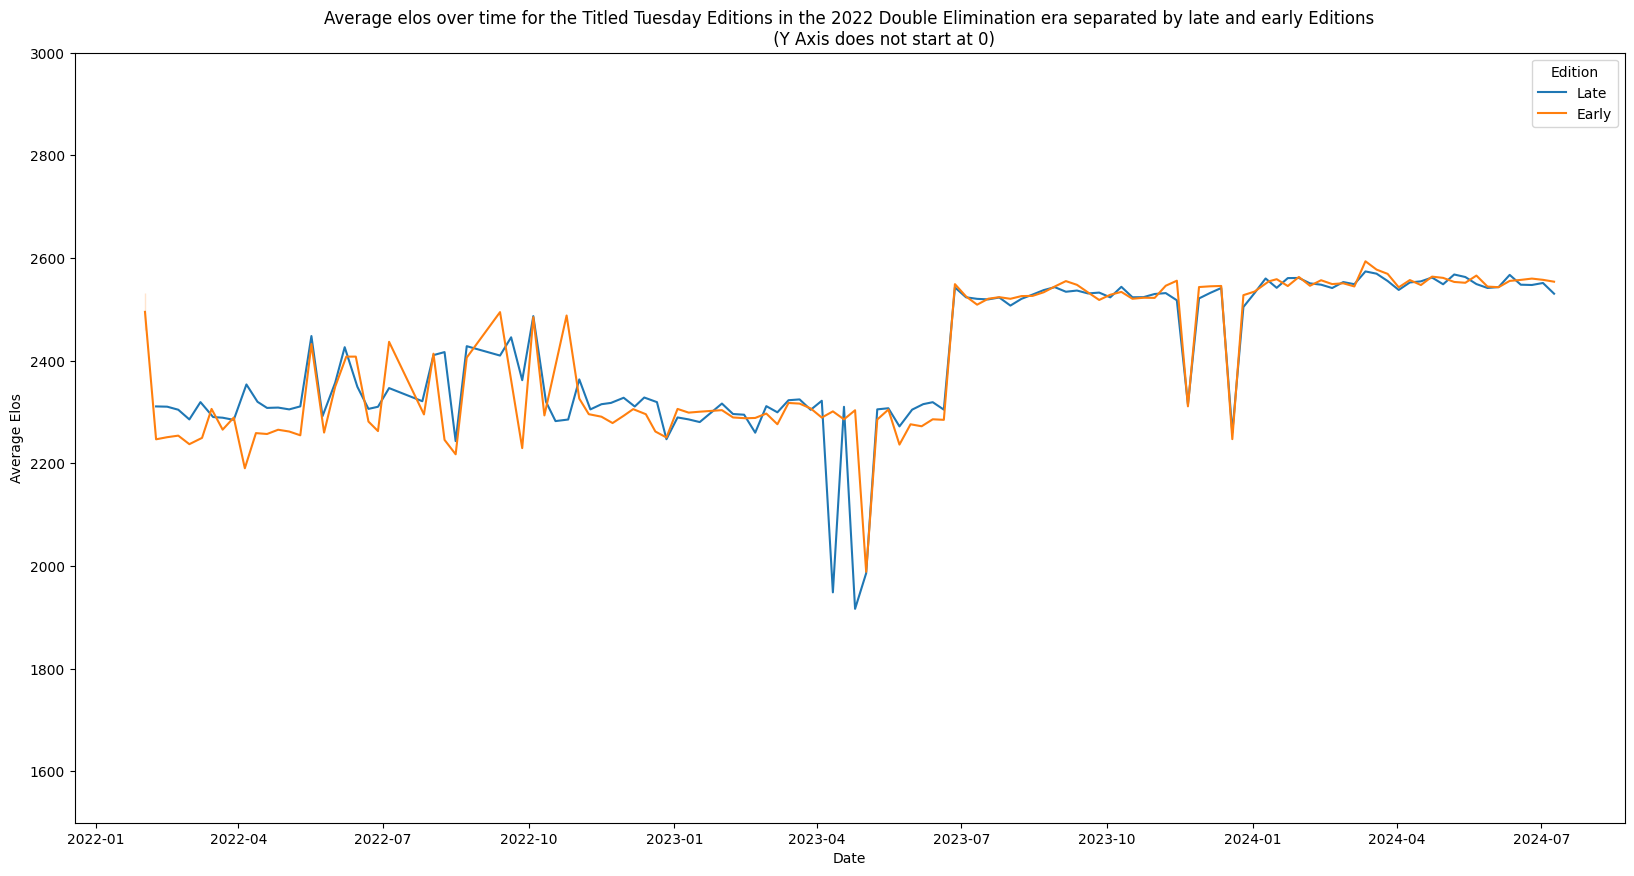

In [19]:
ax = plt.subplots(figsize=(20, 10))[1]

sns.lineplot(
    data=df_average_elos,
    x="Date",
    y="avg_elo",
    hue="Edition",
    ax=ax,
)

ax.set_ylabel("Average Elos")
ax.set_title(
    """Average elos over time for the Titled Tuesday Editions in the 2022 Double Elimination era separated by late and early Editions
             (Y Axis does not start at 0)"""
)
ax.set_ylim(1500, 3000)

## Notes

We see two distinct details here, first there's a spike in the average elo just after Juli 2023.

The second is a few very noticeable dips, first around April 2024 and another two dips just before January 2024.

Let's inverstigate why this could be.


In [20]:
df_average_elos[
    (df_average_elos["Date"] < "2023-06-01") & (df_average_elos["avg_elo"] < 2000)
].sort_values("avg_elo", ascending=True).head(10)

,Event,Date,avg_elo,Edition
222,Titled Tuesday Blitz April 25 Late 2023,2023-04-25,1916.612626,Late
186,Titled Tuesday Blitz April 11 Late 2023,2023-04-11,1948.746524,Late
14,Titled Tuesday Blitz May 2 Late 2023,2023-05-02,1986.075374,Late
28,Titled Tuesday Blitz May 2 Early 2023,2023-05-02,1988.835781,Early


In [21]:
df_average_elos[
    (df_average_elos["Date"] > "2023-11-01") & (df_average_elos["avg_elo"] < 2500)
].sort_values("avg_elo", ascending=True).head(10)

,Event,Date,avg_elo,Edition
81,December 19 Early 2023,2023-12-19,2247.210697,Early
9,December 19 Late 2023,2023-12-19,2260.166567,Late
35,November 21 Early 2023,2023-11-21,2311.141943,Early
12,November 21 Late 2023,2023-11-21,2315.015817,Late


The Dates that we need to analyze are:

- 2023-04-25
- 2023-04-11
- 2023-05-02
- 2023-11-12
- 2023-12-19


My first hypothesis is that there is a big tournament happening during these days, let's check that.
